# Computer Vision - Project
imports

In [68]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import h5py
import requests
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
import tensorflow as tf
import h5py, requests, os
import matplotlib.patches as patches
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten, BatchNormalization, ZeroPadding2D, GlobalMaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import LSTM
from keras.layers import Resizing
from tqdm import tqdm

In [69]:
# IMG_SIZE = (64, 64)
# IMG_SHAPE = IMG_SIZE + (3,)
# base_model = tf.keras.applications.resnet(input_shape=IMG_SHAPE,
#                                                include_top=False,
#                                                weights='imagenet')
# base_model.trainable = False

Constants

In [70]:
#ZIP_PATH = "https://drive.google.com/drive/folders/1jzHYpTwywUYA53nMGHVROSuVO14hEueq?usp=sharing/"
FILE_NAME ="SynthText_train.h5"
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
tf.keras.backend.clear_session()
SIZE=224


In [71]:
def sort_points(points, center):
    # calculate the angle of each point from the center point
    angles = np.arctan2(points[:, 1] - center[1], points[:, 0] - center[0])
    # sort the points by angle
    sorted_points = points[np.argsort(angles)]
    return sorted_points

In [72]:
def draw_training_curve(history):
	"""
	Draw training curve
	Parameters:
		history - contains loss and accuracy from training
	Returns:
		None
	"""
	plt.figure(1)

	# History for accuracy
	plt.subplot(211)
	plt.plot(history.history['accuracy'])
	plt.plot(history.history['val_accuracy'])
	plt.title('model accuracy')
	plt.ylabel('accuracy')
	plt.xlabel('epoch')
	plt.legend(['train', 'test'], loc='upper left')

	# History for loss
	plt.subplot(212)
	plt.plot(history.history['loss'])
	plt.plot(history.history['val_loss'])
	plt.title('model loss')
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'test'], loc='upper left')

	plt.show()

In [73]:
def draw_points(image, points, color=(255, 0, 0), radius=3):
    # create a copy of the image
    img = image.copy()
    # iterate over the points and draw them on the image
    for point in points:
        cv2.circle(img, tuple(map(int, point)), radius, color, -1)
    return img


In [74]:
def get_bb(img, bbs, indx):
    x1 = int(bbs[0,0,indx])
    y1 = int(bbs[1,0,indx])
    x2 = int(bbs[0,1,indx])
    y2 = int(bbs[1,1,indx])
    x3 = int(bbs[0,2,indx])
    y3 = int(bbs[1,2,indx])
    x4 = int(bbs[0,3,indx])
    y4 = int(bbs[1,3,indx])
    # calculate bounding rectangle
    top_left_x = max(0, min([x1,x2,x3,x4]))
    top_left_y = max(0, min([y1,y2,y3,y4]))
    bot_right_x = max(0, max([x1,x2,x3,x4]))
    bot_right_y = max(0, max([y1,y2,y3,y4]))
    # points = np.float32([[x1, y1], [x2, y2], [x3, y3], [x4, y4]])
    
    # create an empty image with the same shape as the input image
    # mask = np.zeros_like(img[:,:,0])
    # create a list of the bounding box points in the correct format
    # bounding_box = np.array([points], dtype=np.int32)
    # fill the area inside the bounding box with white
    # cv2.fillPoly(mask, bounding_box, 255)
    # apply the mask to the image
    ####res = cv2.bitwise_and(img, mask)
    # try1 = np.array(np.where(mask == 255, 255, 0), dtype=np.uint8)
    # print(x)
    # inv_mask = cv2.bitwise_not(mask)
    # res2 = cv2.bitwise_and(img, inv_mask)
    # bb2 = np.int32([[top_left_x, bot_right_y], [bot_right_x, bot_right_y],[bot_right_x,top_left_y], [top_left_x,top_left_y]])
    # print(bb2)
    # mask2 = np.zeros_like(img)
    # # bb2 = np.array(frame, dtype=np.int32)
    # cv2.fillPoly(mask2, bb2, (255, 255, 255))
    # mask = mask[top_left_y:bot_right_y+1, top_left_x:bot_right_x+1]
    res = img[top_left_y:bot_right_y+1, top_left_x:bot_right_x+1]

    #res = img[top_left_y:bot_right_y+1, top_left_x:bot_right_x+1]
    #flipping
    """"if(x2 < x1):
        res = cv2.flip(res, 1)
    if(y2 < y1):
        res = cv2.flip(res, 0)
    plt.imshow(mask)
    plt.show()
    print(mask.shape)"""
    return res

In [75]:
def font_to_num(font):
    if font == b'Alex Brush':
        return 0
    elif font == b'Titillium Web':
        return 1
    elif font == b'Sansation':
        return 2
    elif font == b'Open Sans':
        return 3
    else:
        return 4

In [76]:
def num_to_font(font):
    if font == 0:
        return b'Alex Brush'
    elif font == 1:
        return b'Titillium Web'
    elif font == 2:
        return b'Sansation'
    elif font == 3:
        return b'Open Sans'
    else:
        return b'Ubuntu Mono'

In [77]:
def print_label(set, index):
    line = set[index]
    max = np.argmax(line)
    print(num_to_font(max))

In [78]:
def print_font(max):
     print(num_to_font(max))

In [79]:
def print_photo_from_set(set_x, set_y, index, font):
    plt.imshow(set_x[index], cmap='gray')
    plt.show()
    print_font(font)

In [80]:
def prepare_img(img, bbs, index, size):
    x1 = int(bbs[0,0,index])
    y1 = int(bbs[1,0,index])
    x2 = int(bbs[0,1,index])
    y2 = int(bbs[1,1,index])
    x3 = int(bbs[0,2,index])
    y3 = int(bbs[1,2,index])
    x4 = int(bbs[0,3,index])
    y4 = int(bbs[1,3,index])
    # calculate bounding rectangle
    top_left_x = max(0, min([x1,x2,x3,x4]))
    top_left_y = max(0, min([y1,y2,y3,y4]))
    bot_right_x = max(0, max([x1,x2,x3,x4]))
    bot_right_y = max(0, max([y1,y2,y3,y4]))

    cropped = img[top_left_y:bot_right_y+1, top_left_x:bot_right_x+1]
    # _, cropped = cv2.threshold(cropped,127,255,cv2.THRESH_TRIANGLE)
    # print(cropped.shape)
    cropped = tf.image.resize(cropped, (size, size), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # cropped = tf.image.rgb_to_grayscale(cropped)
    # # print(cropped.shape)
    cropped = tf.image.convert_image_dtype(cropped, tf.float32)
    # plt.imshow(cropped, cmap='gray')
    # plt.show()
    return cropped

In [81]:
from pathlib import Path
def create_dirs():
    Path('main_directory').mkdir(parents=True, exist_ok=True)
    Path('main_directory/Alex Brush').mkdir(parents=True, exist_ok=True)
    Path('main_directory/Titillium Web').mkdir(parents=True, exist_ok=True)
    Path('main_directory/Sansation').mkdir(parents=True, exist_ok=True)
    Path('main_directory/Open Sans').mkdir(parents=True, exist_ok=True)
    Path('main_directory/Ubuntu Mono').mkdir(parents=True, exist_ok=True)

In [82]:
def is_num_or_letter(inp):
    # res= ((inp >= ord('a') and inp <= ord('z')) or (inp >= ord('A') and inp <= ord('Z'))) or (inp>=ord('0') and inp<=ord('9'))
    # # print(chr(inp)+"="+str(res))
    if(inp==ord('.') or inp==ord(',') or inp==ord(':') or inp==ord(';')):
        return False
    return True

In [83]:
db = h5py.File(FILE_NAME, 'r')

In [84]:
def get_data_set(db, size: int):
    
    create_dirs()
    im_names = list(db['data'].keys())
    train_x = []
    train_y = []
    num = 0
    for i in tqdm(range(0, len(im_names)-1)):
        im = im_names[i]
        img  = db['data'][im][:]
        fonts = db['data'][im].attrs['font']
        txts = db['data'][im].attrs['txt']
        charBBs = db['data'][im].attrs['charBB']
        wordBBs = db['data'][im].attrs['wordBB']
        font_indx = 0 
        char_indx = 0
        # print(im)
        for j in range(0, len(txts)):
            if(j%8!=0):
                cropped = prepare_img(img, wordBBs, j, size)
                path = 'main_directory/'+fonts[font_indx].decode('UTF-8')+'/'+im+'_'+str(num)+'.jpg' 
                # print(path)
                tf.keras.utils.save_img(path,cropped)
                # db['data'][im] = 0
                num+=1
                for k in range(0, len(txts[j])):
                    if(is_num_or_letter(txts[j][k])):
                        cropped = prepare_img(img, charBBs, char_indx, size)
                        path = 'main_directory/'+fonts[font_indx].decode('UTF-8')+'/'+im+'_'+str(num)+'.jpg'
                        # print(path)
                        tf.keras.utils.save_img(path,cropped)
                        num+=1
                        # train_x.append(cropped)
                        # train_y.append(font_to_num(fonts[font_indx]))
                    char_indx+=1
                        # plt.imshow(cropped, cmap='gray')
                        # plt.show()
                        # print(fonts[font_indx])
            else:
                # cropped = prepare_img(img, wordBBs, j, size)
                # db['data'][im][:].resize(224,224,3)
                # db['data'][im][:] = cropped
                # name = 'test_set/'+fonts[font_indx].decode('UTF-8')+'/'+im+'_'+str(num)+'.jpg' 
                # add_res_to_db(db_test,name,cropped,charBBs[:,:,j:j+len(txts[j])], wordBBs[:,:,j], txts[j])
                # path = 'test_set/'+fonts[font_indx].decode('UTF-8')+'/'+im+'_'+str(num)+'.jpg' 
                # tf.keras.utils.save_img(path,cropped)
                char_indx+=len(txts[j])
            font_indx += len(txts[j])
    print(num)
    # return train_x, train_y

In [85]:
from download_h5py_db import download_h5py_db
if not Path("main_directory").exists():
    download_h5py_db()
    get_data_set(db, SIZE)
# train_x, train_y = 

In [124]:
from keras.preprocessing.image import ImageDataGenerator
def data_augmentation():
    datagen =  ImageDataGenerator(
        horizontal_flip=True, rotation_range=180, fill_mode='reflect', channel_shift_range=0.8,#
         shear_range=30,vertical_flip=False, brightness_range=(0.2, 0.8),# 
     rescale=1/255,dtype='float32',validation_split=0.1)
    Path('augmented').mkdir(exist_ok=True)
    it = datagen.flow_from_directory('main_directory', batch_size=18, subset='training', class_mode='categorical',
    save_to_dir='augmented',
     shuffle=True, seed=1, keep_aspect_ratio=True)
    val_it = datagen.flow_from_directory('main_directory', batch_size=18, subset='validation', class_mode='categorical',
    save_to_dir='augmented',
     shuffle=True)
    return it, val_it, datagen

In [126]:
it, val_it, datagen = data_augmentation()

Found 26859 images belonging to 5 classes.
Found 2981 images belonging to 5 classes.


Found 27011 images belonging to 5 classes.
Found 9000 images belonging to 5 classes.

In [88]:
# datagen.fit(it, augment=True, seed=0.8, rounds=5)

In [89]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import AveragePooling2D
from keras import regularizers
num_classes = 5
input_size= SIZE

baseModel = tf.keras.applications.ResNet50V2(include_top=False, classes=num_classes,
                         input_shape=(input_size, input_size, 3),
                        weights='imagenet')
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.01))(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(num_classes, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)
# cfg = pretrained_model.get_config()
# cfg['layers'][0]['config']['batch_input_shape'] = (None, input_size, input_size, 3)
# resnet_model = Model.from_config(cfg)
# for i, layer in enumerate(resnet_model.layers):
#     # if i == 1:
#     #     new_weights = pretrained_model.layers[i].get_weights()[0].sum(axis=2, keepdims=True)
#     #     resnet_model.set_weights([new_weights])
#     #     layer.trainable = False
#     # else: 
#         layer.set_weights(pretrained_model.layers[i].get_weights())
#         layer.trainable = False

# x = GlobalMaxPooling2D()(resnet_model.output)
# x = Dense(2048, activation='relu')(x)
# x = Dense(2048, activation='relu')(x)
# outp = Dense(num_classes, activation='softmax')(x)
# model = Model(resnet_model.input, outp)        
    
model.compile(optimizer=tf.keras.optimizers.Adam(0.00003), loss='categorical_crossentropy', metrics=['accuracy'])

In [90]:
def scheduler(epoch, lr):
    # if epoch < 5:
    #     return lr
    # else:
    return lr * 0.1 #tf.math.exp(-0.1)

In [91]:
# callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [94]:
# model.fit(X_train, Y_train, batch_size=16, epochs=20)
# datagen.fit(X_train)
history = model.fit(it, epochs=15, shuffle=True, validation_data=val_it, verbose=1
        #   ,callbacks=[callback]
          )

Epoch 1/15
1493/1493 [==============================] - 579s 387ms/step - loss: 4.3176 - accuracy: 0.4428 - val_loss: 3.5586 - val_accuracy: 0.5374
Epoch 2/15
1493/1493 [==============================] - 569s 381ms/step - loss: 3.0419 - accuracy: 0.5501 - val_loss: 2.5456 - val_accuracy: 0.5917
Epoch 3/15
1493/1493 [==============================] - 578s 387ms/step - loss: 2.1702 - accuracy: 0.5959 - val_loss: 1.8433 - val_accuracy: 0.6307
Epoch 4/15
1493/1493 [==============================] - 569s 381ms/step - loss: 1.6369 - accuracy: 0.6365 - val_loss: 1.4775 - val_accuracy: 0.6394
Epoch 5/15
1493/1493 [==============================] - 566s 379ms/step - loss: 1.3163 - accuracy: 0.6670 - val_loss: 1.2580 - val_accuracy: 0.6706
Epoch 6/15
1493/1493 [==============================] - 563s 377ms/step - loss: 1.1263 - accuracy: 0.6875 - val_loss: 1.0822 - val_accuracy: 0.6934
Epoch 7/15
1493/1493 [==============================] - 558s 374ms/step - loss: 0.9809 - accuracy: 0.7138 - val_

Epoch 1/15
1501/1501 [==============================] - 722s 475ms/step - loss: 5.0276 - accuracy: 0.3560 - val_loss: 3.8665 - val_accuracy: 0.5230
Epoch 2/15
1501/1501 [==============================] - 708s 470ms/step - loss: 3.2900 - accuracy: 0.5168 - val_loss: 2.5762 - val_accuracy: 0.6023
Epoch 3/15
  98/1501 [>.............................] - ETA: 8:35 - loss: 2.6632 - accuracy: 0.5539

In [95]:
score = model.evaluate(val_it)

166/166 [==============================] - 48s 287ms/step - loss: 0.7082 - accuracy: 0.7474


In [96]:
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.7082432508468628 / Test accuracy: 0.7474002242088318


632/632 [==============================] - 161s 254ms/step - loss: 0.2479 - accuracy: 0.6977
632/632 [==============================] - 53s 82ms/step - loss: 1.6858 - accuracy: 0.5157
632/632 [==============================] - 150s 236ms/step - loss: 0.8984 - accuracy: 0.6251

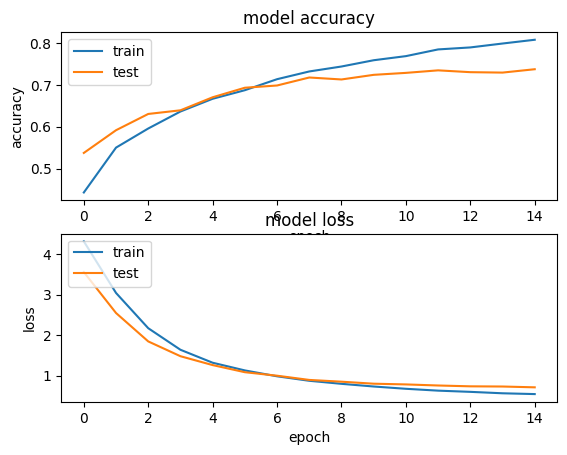

In [97]:
draw_training_curve(history)

In [98]:
model.save('model_res')

INFO:tensorflow:Assets written to: model_res\assets


INFO:tensorflow:Assets written to: model_res\assets


In [ ]:
# model = tf.keras.models.load_model('model_res')

In [ ]:
predict = model.predict(val_it, verbose=1)

166/166 [==============================] - 51s 303ms/step


In [ ]:
# print(predict)

[[0.3467849  0.23168708 0.19020765 0.14412178 0.08719847]
 [0.4208269  0.08442075 0.1518158  0.05579396 0.28714254]
 [0.91571385 0.02389796 0.01419433 0.01691871 0.02927518]
 ...
 [0.25236514 0.14867976 0.25109375 0.13325743 0.21460387]
 [0.16184747 0.2397047  0.21829815 0.25734678 0.12280296]
 [0.9052684  0.02766666 0.01709995 0.01875637 0.03120871]]


b'The'


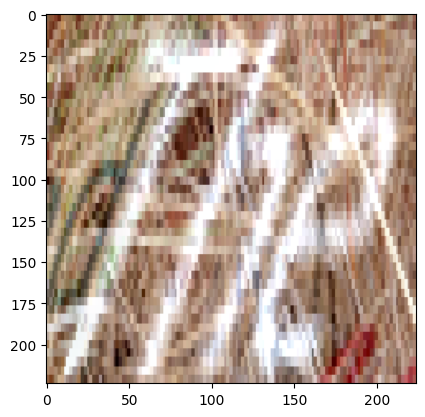

[1 1 1 3]
[[9.4935549e-03 7.9160124e-01 5.0603941e-02 1.4412628e-01 4.1749794e-03]
 [2.0448800e-02 8.9957434e-01 6.2489710e-03 7.3600270e-02 1.2761359e-04]
 [1.8086624e-03 8.2411915e-01 1.9787027e-02 1.5397884e-01 3.0633740e-04]
 [8.1177941e-03 3.4254459e-01 1.3859917e-01 5.0104761e-01 9.6908668e-03]]
1
b'Titillium Web'
b'Titillium Web'
[[[[0.5176471  0.3921569  0.28627452]
   [0.5176471  0.3921569  0.28627452]
   [0.5294118  0.3372549  0.21176472]
   ...
   [0.64705884 0.56078434 0.4784314 ]
   [0.58431375 0.3803922  0.31764707]
   [0.58431375 0.3803922  0.31764707]]

  [[0.5176471  0.3921569  0.28627452]
   [0.5176471  0.3921569  0.28627452]
   [0.5294118  0.3372549  0.21176472]
   ...
   [0.64705884 0.56078434 0.4784314 ]
   [0.58431375 0.3803922  0.31764707]
   [0.58431375 0.3803922  0.31764707]]

  [[0.5176471  0.3921569  0.28627452]
   [0.5176471  0.3921569  0.28627452]
   [0.5294118  0.3372549  0.21176472]
   ...
   [0.64705884 0.56078434 0.4784314 ]
   [0.58431375 0.3803922  0.

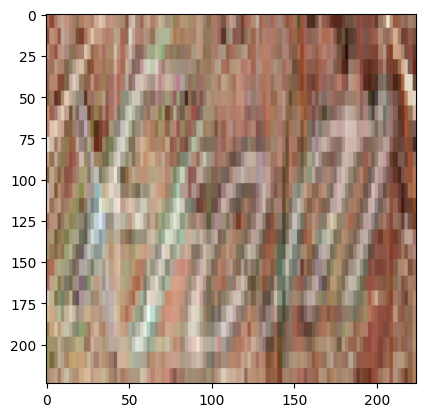

[4 1 0 1 2]
[[0.1801937  0.18036471 0.17721738 0.09187537 0.37034887]
 [0.23230542 0.5392647  0.07833362 0.14838783 0.00170845]
 [0.9698039  0.00393311 0.0169619  0.00490661 0.0043944 ]
 [0.41587424 0.4850854  0.05307264 0.04490664 0.00106116]
 [0.0085704  0.1749197  0.5893808  0.21947326 0.00765582]]
1
b'Sansation'
b'Titillium Web'
[[[[0.6666667  0.4431373  0.36078432]
   [0.6666667  0.4431373  0.36078432]
   [0.5568628  0.28235295 0.20784315]
   ...
   [0.6431373  0.5058824  0.427451  ]
   [0.6156863  0.47450984 0.41176474]
   [0.6156863  0.47450984 0.41176474]]

  [[0.6666667  0.4431373  0.36078432]
   [0.6666667  0.4431373  0.36078432]
   [0.5568628  0.28235295 0.20784315]
   ...
   [0.6431373  0.5058824  0.427451  ]
   [0.6156863  0.47450984 0.41176474]
   [0.6156863  0.47450984 0.41176474]]

  [[0.6666667  0.4431373  0.36078432]
   [0.6666667  0.4431373  0.36078432]
   [0.5568628  0.28235295 0.20784315]
   ...
   [0.6431373  0.5058824  0.427451  ]
   [0.6156863  0.47450984 0.4117

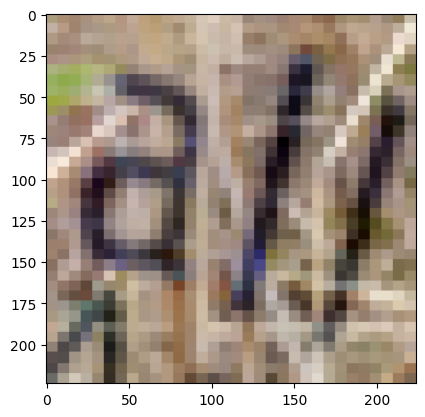

[2 3 2 1]
[[6.7354873e-04 6.0748491e-02 6.0332316e-01 3.3423048e-01 1.0243116e-03]
 [1.1382004e-03 2.4817411e-02 4.6916913e-02 9.2634070e-01 7.8673236e-04]
 [2.4931654e-03 1.7744271e-01 4.1842550e-01 3.9822555e-01 3.4131308e-03]
 [3.0655289e-02 4.0240970e-01 2.6459485e-01 3.0054504e-01 1.7951354e-03]]
2
b'Titillium Web'
b'Sansation'
[[[[0.6666667  0.6117647  0.48627454]
   [0.6666667  0.6117647  0.48627454]
   [0.6666667  0.6117647  0.48627454]
   ...
   [0.79215693 0.75294125 0.6784314 ]
   [0.79215693 0.75294125 0.6784314 ]
   [0.79215693 0.75294125 0.6784314 ]]

  [[0.6666667  0.6117647  0.48627454]
   [0.6666667  0.6117647  0.48627454]
   [0.6666667  0.6117647  0.48627454]
   ...
   [0.79215693 0.75294125 0.6784314 ]
   [0.79215693 0.75294125 0.6784314 ]
   [0.79215693 0.75294125 0.6784314 ]]

  [[0.6666667  0.6117647  0.48627454]
   [0.6666667  0.6117647  0.48627454]
   [0.6666667  0.6117647  0.48627454]
   ...
   [0.79215693 0.75294125 0.6784314 ]
   [0.79215693 0.75294125 0.6784

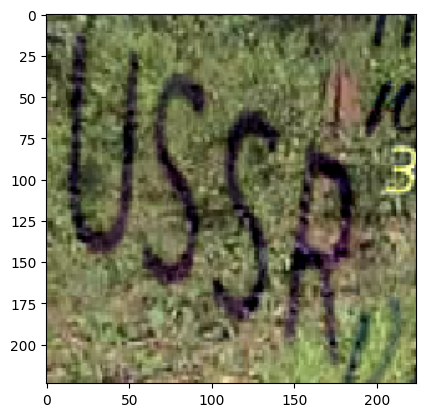

[0 3 1 1 3]
[[7.3033834e-01 2.2460254e-01 3.6588293e-03 3.9382469e-02 2.0177434e-03]
 [9.1902260e-03 8.3441228e-02 6.2213946e-02 8.4423947e-01 9.1513072e-04]
 [1.8893472e-04 4.9944937e-01 1.0528189e-02 4.8979080e-01 4.2759209e-05]
 [2.2437593e-02 6.5733826e-01 6.4803012e-02 2.5505227e-01 3.6885063e-04]
 [2.8638479e-03 1.3171315e-01 7.8474991e-02 7.8305054e-01 3.8975473e-03]]
1
b'Open Sans'
b'Titillium Web'
[[[[0.5019608  0.53333336 0.38823533]
   [0.34901962 0.3803922  0.23529413]
   [0.34901962 0.3803922  0.23529413]
   ...
   [0.10980393 0.12941177 0.14901961]
   [0.10980393 0.12941177 0.14901961]
   [0.36078432 0.38431376 0.32156864]]

  [[0.5019608  0.53333336 0.38823533]
   [0.34901962 0.3803922  0.23529413]
   [0.34901962 0.3803922  0.23529413]
   ...
   [0.10980393 0.12941177 0.14901961]
   [0.10980393 0.12941177 0.14901961]
   [0.36078432 0.38431376 0.32156864]]

  [[0.3372549  0.3647059  0.23137257]
   [0.34117648 0.36862746 0.23529413]
   [0.34117648 0.36862746 0.23529413]
  

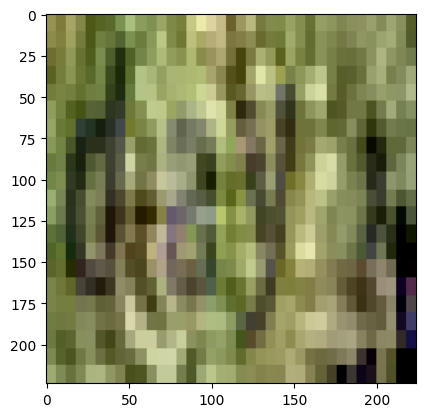

[0 4 0 2]
[[0.47746053 0.07202544 0.16336328 0.07608566 0.21106505]
 [0.15374908 0.00168914 0.08799425 0.00327197 0.7532956 ]
 [0.775345   0.00606718 0.05317789 0.00851661 0.1568933 ]
 [0.11564483 0.04711747 0.52040696 0.02523855 0.2915922 ]]
0
b'Ubuntu Mono'
b'Alex Brush'
[[[[0.5882353  0.57254905 0.32156864]
   [0.5882353  0.57254905 0.32156864]
   [0.5882353  0.57254905 0.32156864]
   ...
   [0.32941177 0.36862746 0.16862746]
   [0.32941177 0.36862746 0.16862746]
   [0.32941177 0.36862746 0.16862746]]

  [[0.5882353  0.57254905 0.32156864]
   [0.5882353  0.57254905 0.32156864]
   [0.5882353  0.57254905 0.32156864]
   ...
   [0.32941177 0.36862746 0.16862746]
   [0.32941177 0.36862746 0.16862746]
   [0.32941177 0.36862746 0.16862746]]

  [[0.5882353  0.57254905 0.32156864]
   [0.5882353  0.57254905 0.32156864]
   [0.5882353  0.57254905 0.32156864]
   ...
   [0.32941177 0.36862746 0.16862746]
   [0.32941177 0.36862746 0.16862746]
   [0.32941177 0.36862746 0.16862746]]

  ...

  [[0.61

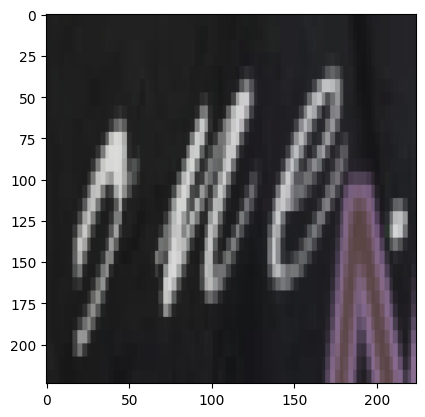

[0 0 0 0]
[[9.99304175e-01 3.36741432e-05 2.02616589e-04 1.45735932e-04
  3.13752011e-04]
 [9.84178126e-01 5.92492695e-04 5.79234259e-03 3.62366292e-04
  9.07467585e-03]
 [9.99908447e-01 5.16165892e-06 3.13988239e-05 2.31016438e-05
  3.19400679e-05]
 [9.99957085e-01 2.20651668e-06 2.29714769e-05 1.31251645e-05
  4.58252453e-06]]
0
b'Alex Brush'
b'Alex Brush'
[[[[0.11764707 0.11764707 0.12156864]
   [0.11764707 0.11764707 0.12156864]
   [0.11764707 0.11764707 0.12156864]
   ...
   [0.14117648 0.14117648 0.15686275]
   [0.14117648 0.14117648 0.15686275]
   [0.14117648 0.14117648 0.15686275]]

  [[0.11764707 0.11764707 0.12156864]
   [0.11764707 0.11764707 0.12156864]
   [0.11764707 0.11764707 0.12156864]
   ...
   [0.14117648 0.14117648 0.15686275]
   [0.14117648 0.14117648 0.15686275]
   [0.14117648 0.14117648 0.15686275]]

  [[0.11764707 0.11764707 0.12156864]
   [0.11764707 0.11764707 0.12156864]
   [0.11764707 0.11764707 0.12156864]
   ...
   [0.14117648 0.14117648 0.15686275]
   [0.

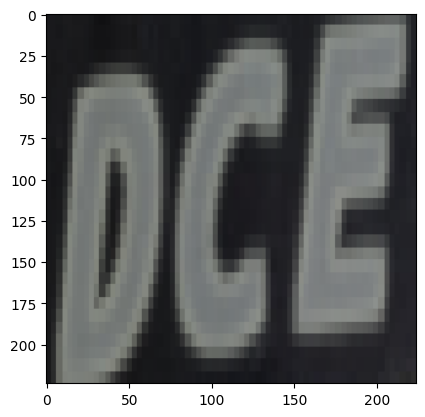

[4 3 4 3]
[[8.8668300e-04 1.0613494e-03 4.9821958e-03 2.6249624e-04 9.9280727e-01]
 [2.3173289e-03 2.0275532e-01 3.7425601e-01 4.1936365e-01 1.3077322e-03]
 [8.8895848e-03 4.2215548e-02 5.8593944e-02 9.7757271e-03 8.8052523e-01]
 [7.9340898e-03 8.8901125e-02 2.9150391e-01 3.3167976e-01 2.7998111e-01]]
3
b'Ubuntu Mono'
b'Open Sans'
[[[[0.09803922 0.09803922 0.10980393]
   [0.09803922 0.09803922 0.10980393]
   [0.09803922 0.09803922 0.10980393]
   ...
   [0.12941177 0.13333334 0.14901961]
   [0.12941177 0.13333334 0.14901961]
   [0.12941177 0.13333334 0.14901961]]

  [[0.09803922 0.09803922 0.10980393]
   [0.09803922 0.09803922 0.10980393]
   [0.09803922 0.09803922 0.10980393]
   ...
   [0.12941177 0.13333334 0.14901961]
   [0.12941177 0.13333334 0.14901961]
   [0.12941177 0.13333334 0.14901961]]

  [[0.09803922 0.09803922 0.10980393]
   [0.09803922 0.09803922 0.10980393]
   [0.09803922 0.09803922 0.10980393]
   ...
   [0.12941177 0.13333334 0.14901961]
   [0.12941177 0.13333334 0.149019

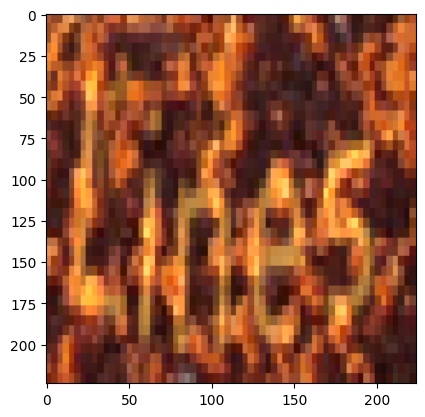

[3 4 2 2 2 2]
[[0.05334942 0.08320912 0.29041982 0.4062046  0.16681701]
 [0.00364413 0.03776992 0.25362498 0.07518169 0.6297793 ]
 [0.02657933 0.2320314  0.42183366 0.22782078 0.09173482]
 [0.0052797  0.12292688 0.6535278  0.18612306 0.03214252]
 [0.01679985 0.41091195 0.4160558  0.128027   0.02820528]
 [0.00300134 0.02360845 0.57652414 0.01684842 0.38001767]]
2
b'Sansation'
b'Sansation'
[[[[0.65882355 0.3647059  0.21568629]
   [0.65882355 0.3647059  0.21568629]
   [0.65882355 0.3647059  0.21568629]
   ...
   [0.7058824  0.31764707 0.15294118]
   [0.7058824  0.31764707 0.15294118]
   [0.7058824  0.31764707 0.15294118]]

  [[0.65882355 0.3647059  0.21568629]
   [0.65882355 0.3647059  0.21568629]
   [0.65882355 0.3647059  0.21568629]
   ...
   [0.7058824  0.31764707 0.15294118]
   [0.7058824  0.31764707 0.15294118]
   [0.7058824  0.31764707 0.15294118]]

  [[0.65882355 0.3647059  0.21568629]
   [0.65882355 0.3647059  0.21568629]
   [0.65882355 0.3647059  0.21568629]
   ...
   [0.7058824 

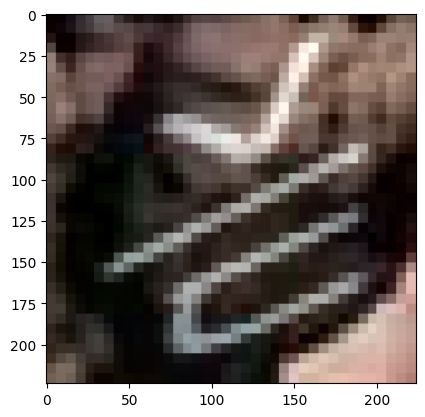

[2 3 2 2]
[[0.00588719 0.06525895 0.5471985  0.37944826 0.00220711]
 [0.19025865 0.05674867 0.28426832 0.46444193 0.00428244]
 [0.00449383 0.24889068 0.6309967  0.11453133 0.0010875 ]
 [0.00554524 0.34783205 0.5486789  0.09638374 0.00156006]]
2
b'Titillium Web'
b'Sansation'
[[[[0.03137255 0.         0.00392157]
   [0.03137255 0.         0.00392157]
   [0.03137255 0.         0.00392157]
   ...
   [0.43529415 0.3529412  0.3137255 ]
   [0.43529415 0.3529412  0.3137255 ]
   [0.43529415 0.3529412  0.3137255 ]]

  [[0.03137255 0.         0.00392157]
   [0.03137255 0.         0.00392157]
   [0.03137255 0.         0.00392157]
   ...
   [0.43529415 0.3529412  0.3137255 ]
   [0.43529415 0.3529412  0.3137255 ]
   [0.43529415 0.3529412  0.3137255 ]]

  [[0.03137255 0.         0.00392157]
   [0.03137255 0.         0.00392157]
   [0.03137255 0.         0.00392157]
   ...
   [0.43529415 0.3529412  0.3137255 ]
   [0.43529415 0.3529412  0.3137255 ]
   [0.43529415 0.3529412  0.3137255 ]]

  ...

  [[0.4

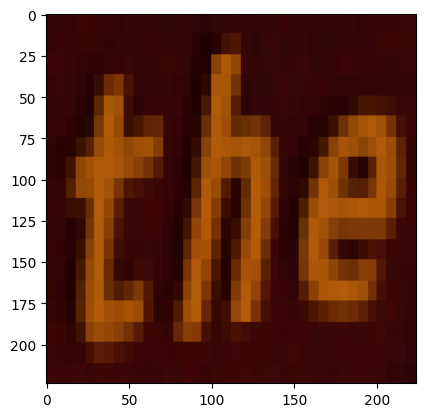

[4 4 4 4]
[[9.3808433e-07 9.0199120e-07 2.3205114e-07 3.6276756e-06 9.9999428e-01]
 [3.4386027e-03 3.8788146e-03 1.0190269e-02 1.6019020e-02 9.6647328e-01]
 [4.0788174e-04 3.5768524e-05 2.2137626e-03 1.0322908e-04 9.9723935e-01]
 [6.7535970e-05 3.1224667e-05 2.7160058e-04 9.4528968e-06 9.9962020e-01]]
4
b'Ubuntu Mono'
b'Ubuntu Mono'
[[[[0.21176472 0.02352941 0.01960784]
   [0.21176472 0.02352941 0.01960784]
   [0.21176472 0.02352941 0.01960784]
   ...
   [0.22352943 0.02745098 0.01568628]
   [0.22352943 0.02745098 0.01568628]
   [0.22352943 0.02745098 0.01568628]]

  [[0.21176472 0.02352941 0.01960784]
   [0.21176472 0.02352941 0.01960784]
   [0.21176472 0.02352941 0.01960784]
   ...
   [0.22352943 0.02745098 0.01568628]
   [0.22352943 0.02745098 0.01568628]
   [0.22352943 0.02745098 0.01568628]]

  [[0.21176472 0.02352941 0.01960784]
   [0.21176472 0.02352941 0.01960784]
   [0.21176472 0.02352941 0.01960784]
   ...
   [0.22352943 0.02745098 0.01568628]
   [0.22352943 0.02745098 0.0156

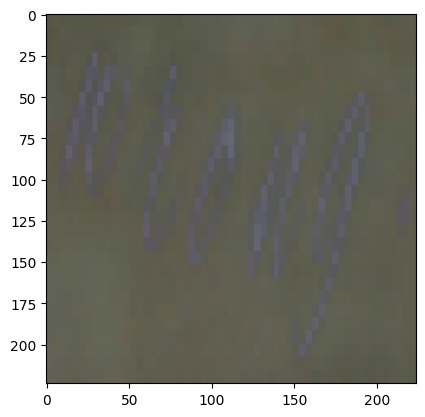

[0 0 0 0 0 0]
[[9.9975258e-01 1.9761306e-05 1.5442469e-04 5.5677305e-05 1.7574461e-05]
 [9.9951482e-01 3.6872239e-05 2.9283666e-04 1.1131470e-04 4.4228927e-05]
 [9.9983788e-01 7.8401144e-06 1.2184531e-04 2.7195845e-05 5.2070664e-06]
 [9.9782419e-01 2.0550741e-04 1.0571280e-03 3.4022584e-04 5.7294394e-04]
 [9.9933249e-01 8.2063110e-05 2.5154813e-04 2.0116940e-04 1.3265923e-04]
 [9.9765849e-01 6.3691189e-04 9.5343514e-04 6.9088716e-04 6.0255934e-05]]
0
b'Alex Brush'
b'Alex Brush'
[[[[0.34117648 0.3372549  0.27450982]
   [0.34117648 0.3372549  0.27450982]
   [0.34117648 0.3372549  0.27450982]
   ...
   [0.36862746 0.35686275 0.29803923]
   [0.36862746 0.35686275 0.29803923]
   [0.36862746 0.35686275 0.29803923]]

  [[0.34117648 0.3372549  0.27450982]
   [0.34117648 0.3372549  0.27450982]
   [0.34117648 0.3372549  0.27450982]
   ...
   [0.36862746 0.35686275 0.29803923]
   [0.36862746 0.35686275 0.29803923]
   [0.36862746 0.35686275 0.29803923]]

  [[0.34117648 0.3372549  0.27450982]
   [0

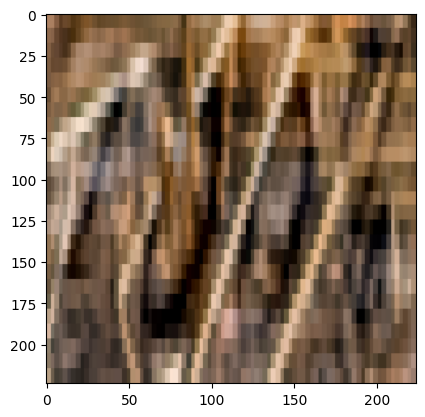

[0 0 0 0 2]
[[0.7708421  0.10872247 0.04649298 0.05858478 0.01535764]
 [0.8911874  0.01743431 0.05545835 0.02180233 0.01411765]
 [0.6776298  0.07108978 0.06505516 0.18081692 0.00540837]
 [0.7668214  0.04575837 0.10379339 0.05525045 0.02837636]
 [0.26531562 0.04900617 0.33889404 0.09011624 0.25666794]]
0
b'Alex Brush'
b'Alex Brush'
[[[[0.6745098  0.5058824  0.38431376]
   [0.6745098  0.5058824  0.38431376]
   [0.6745098  0.5058824  0.38431376]
   ...
   [0.22352943 0.15686275 0.09019608]
   [0.22352943 0.15686275 0.09019608]
   [0.22352943 0.15686275 0.09019608]]

  [[0.6745098  0.5058824  0.38431376]
   [0.6745098  0.5058824  0.38431376]
   [0.6745098  0.5058824  0.38431376]
   ...
   [0.22352943 0.15686275 0.09019608]
   [0.22352943 0.15686275 0.09019608]
   [0.22352943 0.15686275 0.09019608]]

  [[0.6745098  0.5058824  0.38431376]
   [0.6745098  0.5058824  0.38431376]
   [0.6745098  0.5058824  0.38431376]
   ...
   [0.22352943 0.15686275 0.09019608]
   [0.22352943 0.15686275 0.090196

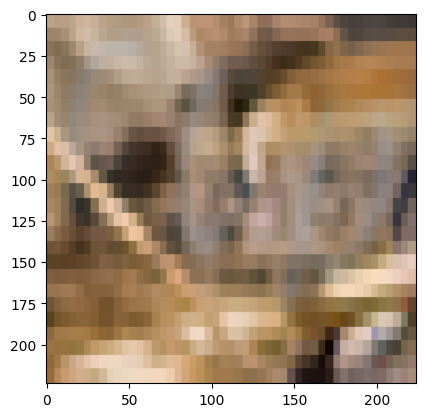

[1 0 0 0]
[[0.02721567 0.57296443 0.23500775 0.14851099 0.01630121]
 [0.909797   0.00856224 0.03204113 0.01159489 0.03800468]
 [0.3829996  0.06810739 0.1593052  0.07938506 0.31020278]
 [0.3264916  0.11096606 0.2813661  0.17385562 0.10732062]]
0
b'Sansation'
b'Alex Brush'
[[[[0.7490196  0.63529414 0.5137255 ]
   [0.7490196  0.63529414 0.5137255 ]
   [0.7490196  0.63529414 0.5137255 ]
   ...
   [0.24313727 0.21960786 0.21176472]
   [0.24313727 0.21960786 0.21176472]
   [0.24313727 0.21960786 0.21176472]]

  [[0.7490196  0.63529414 0.5137255 ]
   [0.7490196  0.63529414 0.5137255 ]
   [0.7490196  0.63529414 0.5137255 ]
   ...
   [0.24313727 0.21960786 0.21176472]
   [0.24313727 0.21960786 0.21176472]
   [0.24313727 0.21960786 0.21176472]]

  [[0.7490196  0.63529414 0.5137255 ]
   [0.7490196  0.63529414 0.5137255 ]
   [0.7490196  0.63529414 0.5137255 ]
   ...
   [0.24313727 0.21960786 0.21176472]
   [0.24313727 0.21960786 0.21176472]
   [0.24313727 0.21960786 0.21176472]]

  ...

  [[0.6   

KeyboardInterrupt: 

In [137]:
# test_path = 'test_diresctory'

size=SIZE
im_names = list(db['data'].keys())
num = 0
prediction_arr=[]
test_y = []
for i in range(0, len(im_names)-1):
    im = im_names[i]
    img  = db['data'][im][:]
    fonts = db['data'][im].attrs['font']
    txts = db['data'][im].attrs['txt']
    charBBs = db['data'][im].attrs['charBB']
    wordBBs = db['data'][im].attrs['wordBB']
    font_indx = 0 
    char_indx = 0
    # print(im)
    for j in range(0, len(txts)):
        if(j%8==0):
            test_x = []
            cropped = prepare_img(img, wordBBs, j, size)
            path = 'main_directory/'+fonts[font_indx].decode('UTF-8')+'/'+im+'_'+str(num)+'.jpg' 
            test_x.append(cropped)
            num+=1
            
            for k in range(0, len(txts[j])):
                if(is_num_or_letter(txts[j][k])):
                    cropped = prepare_img(img, charBBs, char_indx, size)
                    path = 'main_directory/'+fonts[font_indx].decode('UTF-8')+'/'+im+'_'+str(num)+'.jpg'
                    test_x.append(cropped)
                    num+=1
                char_indx+=1
            test_x = np.asarray(test_x, dtype=np.float32)
            # print(test_x)
            reses = model.predict(test_x, verbose=0)
            # print(reses)
            maxes = np.argmax(reses, axis=1)
            prediction = np.bincount(maxes).argmax()
            for k in range(0, len(txts[j])):
                test_y.append(font_to_num(fonts[font_indx]))
                prediction_arr.append(prediction)
            # if(fonts[font_indx]==b'Open Sans'):
            print(txts[j])
            plt.imshow(test_x[0])
            plt.show()
            print(maxes)
            print(reses)
            print(prediction)
            print(fonts[font_indx])
            print(num_to_font(prediction))
            print(test_x)
            # print(str(np.bincount(maxes).argmax())+"-"+str(font_to_num(fonts[font_indx])))
            # print(np.bincount(maxes).argmax())
        else:
            char_indx+=len(txts[j])
        font_indx += len(txts[j])

In [138]:
print(test_y)

[1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 3, 3, 3, 3, 4, 4, 4, 4, 0, 0, 0, 0, 4, 4, 4, 2, 2, 2, 2, 2, 2, 1, 1, 1, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 4, 4, 4]


In [139]:
print(prediction_arr)

[1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4]


In [100]:
prediction_arr_cat = np_utils.to_categorical(prediction_arr, 5)
test_y_cat = np_utils.to_categorical(test_y, 5)

In [112]:
from sklearn.metrics import classification_report
labels=['Alex Brush','Titillium Web','Sansation','Open Sans','Ubuntu Mono']
print(classification_report(test_y, prediction_arr, target_names=labels))

               precision    recall  f1-score   support

   Alex Brush       0.74      0.99      0.85      1134
Titillium Web       0.13      0.11      0.12      1127
    Sansation       0.73      0.77      0.75      1196
    Open Sans       0.05      0.04      0.05       970
  Ubuntu Mono       0.91      0.88      0.89      1259

     accuracy                           0.58      5686
    macro avg       0.51      0.56      0.53      5686
 weighted avg       0.54      0.58      0.56      5686



In [136]:
y_true = test_y
y_pred = prediction_arr
kacc = tf.keras.metrics.Accuracy()
_ = kacc.update_state(y_true, y_pred)
print(f'Keras Accuracy acc: {kacc.result().numpy()*100:.3}')

kbacc = tf.keras.metrics.BinaryAccuracy()
_ = kbacc.update_state(y_true, y_pred)
print(f'Keras BinaryAccuracy acc: {kbacc.result().numpy()*100:.3}')

print(f'SkLearn acc: {accuracy_score(y_true, y_pred)*100:.3}')

Keras Accuracy acc: 58.2
Keras BinaryAccuracy acc: 37.7
SkLearn acc: 58.2
